In [235]:
from pkdtools import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import imageio.v2 as imageio

from mpl_toolkits.mplot3d import Axes3D  # not always necessary but good for older versions
import imageio
import os
import seaborn as sns
import pandas as pd


G = 6.67430e-11  # m^3 kg^-1 s^-2
yr = 3.15576e7  # seconds
au = 1.496e11  # m
M_sun = 1.989e30  # kg

# Center body parameters
r_center = 3.3895e6  # m: Martian radius
M_center = 6.39e23 # kg: Martian mass
rho_center = M_center / (4/3 * np.pi * r_center**3)  # kg/m^3: Martian density

# 
rho = 1e3
tau = 0.3   # optical depth
r = 0.5    # 0.25 - 0.75

R_roche = 1.05 * (M_center/rho)**(1/3)

Sigma = 4 * rho * r * tau / 3

orbit_radius = 3 * r_center      # Roche limit is a bit larger: 2.5 r_center


orbit_speed = np.sqrt(G * M_center / orbit_radius)
omega_orb = np.sqrt(G * M_center / (orbit_radius)**3)

timestep = 1.83001e-07 * yr / 2/np.pi 
period_orb = 2 * np.pi / omega_orb
escape_speed = np.sqrt(2 * G * 4/3 * rho * r**3 / r)

unit_speed = omega_orb * r


lambda_crit = 4 * np.pi**2 * G * Sigma / omega_orb**2
Lx = 5 * lambda_crit
Ly = 5 * lambda_crit
Lz = 5 * r   # 5 m
timestep = 9.9e-8 * yr / 2 / np.pi  

mean_free_path = Lz / tau
shear_speed = 3/2 * omega_orb * (mean_free_path)
theoretical_collision_speed = Lz / orbit_radius * orbit_speed

r_h = orbit_radius * (2 * 4*np.pi/3 * rho * r**3 / 3 / M_center)**(1/3)
if r_h < r:
    v_rel = 2 * r * omega_orb
else:
    v_rel = np.sqrt(G * 4*np.pi/3 * rho * r**3 / r)
# v_rel = max(escape_speed, shear_speed)
Q = v_rel * omega_orb / np.pi / G / Sigma

print('Oribit Period (h): ', period_orb/3600)
print('time steps: ', period_orb/timestep)
print('orbital radius: ', orbit_radius, orbit_radius/ R_roche)
print('orbital speed (m/s): ', orbit_speed)
print('lambda crit (m): ', lambda_crit)
print('Surface density (kg/m^2): ', Sigma)
print('Scale height: ', Lz / orbit_radius)
print('Unit speed (m/s): ', unit_speed)
print('Escape speed: ', escape_speed/unit_speed)
print('Shear speed: ', shear_speed/unit_speed)

print('Theoretical collision speed: ', theoretical_collision_speed/unit_speed)
print('dimensions: ', Lx, Ly, Lz)
print('Toomre parameter Q: ', Q)

Oribit Period (h):  8.665815055093091
time steps:  62741.171501573524
orbital radius:  10168500.0 1.1243477138551115
orbital speed (m/s):  2047.9759129493325
lambda crit (m):  12.991507641874882
Surface density (kg/m^2):  200.0
Scale height:  2.4585730442051434e-07
Unit speed (m/s):  0.00010070196749517295
Escape speed:  2.0946876708897357
Shear speed:  25.0
Theoretical collision speed:  5.0
dimensions:  64.9575382093744 64.9575382093744 2.5
Toomre parameter Q:  1.2696953534588404


In [236]:
print('steps for one orbital period', period_orb / yr * 2*np.pi / 9.96e-8), escape_speed, shear_speed

steps for one orbital period 62363.212637106226


(None, 0.0002109391697464777, 0.002517549187379324)

In [237]:
Lx/au, max(shear_speed, escape_speed), orbit_radius/au

(4.342081431107915e-10, 0.002517549187379324, 6.797125668449198e-05)

In [182]:


# plot gif of spins
def plot_spin_gif(filenames, plot = 'spin rate', output_path='gif/Mars_ring_spin.gif'):
    images = []

    for idx, filename in enumerate(filenames):
        print(f"Processing frame {idx} of {len(filenames)}")
        Particles = ss_in(filename, units='mks')
        p_spin = np.zeros((len(Particles), 3))
        p_spin_rate = np.zeros(len(Particles))
        obliquity = np.zeros(len(Particles))
        for i in range(len(Particles)):
            p_spin[i] = np.array([Particles[i].wx, Particles[i].wy, Particles[i].wz + omega_orb ])
            p_spin_rate[i] = np.linalg.norm(p_spin[i])
            obliquity[i] = np.arccos(p_spin[i, 2] / np.linalg.norm(p_spin[i])) * 180/np.pi

        
        
        if plot == 'spin rate':
            fig = plt.figure()
            plt.title(f'Frame {idx}')
            plt.hist(p_spin_rate/omega_orb, bins=30)
            plt.xlabel('Spin Rate')
            plt.ylabel('Count')

        elif plot == 'obliquity':
            fig = plt.figure()
            plt.title(f'Frame {idx}')
            plt.hist(obliquity, bins=30)
            plt.xlabel('Obliquity')
            plt.ylabel('Count')

        elif plot == 'distribution':
                # Create the figure
            fig = plt.figure(figsize=(8, 8))
            gs = gridspec.GridSpec(4, 4)

            # Main scatter plot
            ax_main = fig.add_subplot(gs[1:4, 0:3])
            ax_main.scatter(obliquity, p_spin_rate/omega_orb,  alpha=0.5)
            ax_main.set_xlim([0, 180])
            ax_main.set_ylim([0, 10])
            ax_main.set_xlabel('Obliquity')
            ax_main.set_ylabel('Spin Rate')
            ax_main.set_title(f'Frame {idx}')

            # Histogram on the top
            ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
            ax_top.hist(obliquity, bins=20, alpha=0.6)
            ax_top.axis('off')  # Optional: hide axes if you want a cleaner look

            # Histogram on the right
            ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
            ax_right.hist(p_spin_rate/omega_orb, bins=20, orientation='horizontal', alpha=0.6)
            ax_right.axis('off')  # Optional

            plt.tight_layout()

            

        # Save the frame to a temporary image
        temp_filename = f'_frame_{idx}.png'
        plt.savefig(temp_filename, dpi=100)
        plt.close(fig)

        images.append(imageio.imread(temp_filename))
        os.remove(f'_frame_{idx}.png')

    # Save the images as a GIF
    imageio.mimsave(output_path, images)

    # Clean up temp files
    # for idx in range(len(filenames)):
    #     os.remove(f'_frame_{idx}.png')

    print(f"GIF saved to {output_path}")

start_index = 0
end_index = 200000
filenames = ['results/tau_2_R_3/ss.' + str(i).zfill(10) for i in range(start_index, end_index, 10000)]

print(filenames)


plot_spin_gif(filenames, plot = 'distribution', output_path='gif/Spin_tau_2_R_3.gif')

['results/tau_2_R_3/ss.0000000000', 'results/tau_2_R_3/ss.0000010000', 'results/tau_2_R_3/ss.0000020000', 'results/tau_2_R_3/ss.0000030000', 'results/tau_2_R_3/ss.0000040000', 'results/tau_2_R_3/ss.0000050000', 'results/tau_2_R_3/ss.0000060000', 'results/tau_2_R_3/ss.0000070000', 'results/tau_2_R_3/ss.0000080000', 'results/tau_2_R_3/ss.0000090000', 'results/tau_2_R_3/ss.0000100000', 'results/tau_2_R_3/ss.0000110000', 'results/tau_2_R_3/ss.0000120000', 'results/tau_2_R_3/ss.0000130000', 'results/tau_2_R_3/ss.0000140000', 'results/tau_2_R_3/ss.0000150000', 'results/tau_2_R_3/ss.0000160000', 'results/tau_2_R_3/ss.0000170000', 'results/tau_2_R_3/ss.0000180000', 'results/tau_2_R_3/ss.0000190000']
Processing frame 0 of 20


/var/folders/yx/n0ldhkpn0hq62r679b3mq7tm0000gn/T/ipykernel_9417/3540951600.py:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


Processing frame 1 of 20
Processing frame 2 of 20
Processing frame 3 of 20
Processing frame 4 of 20
Processing frame 5 of 20
Processing frame 6 of 20
Processing frame 7 of 20
Processing frame 8 of 20
Processing frame 9 of 20
Processing frame 10 of 20
Processing frame 11 of 20
Processing frame 12 of 20
Processing frame 13 of 20
Processing frame 14 of 20
Processing frame 15 of 20
Processing frame 16 of 20
Processing frame 17 of 20
Processing frame 18 of 20
Processing frame 19 of 20
GIF saved to gif/Spin_tau_2_R_3.gif


In [211]:
# plot the particles

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import imageio.v2 as imageio

def plot_particles(filename, output_image='particles.png'):
    Particles = ss_in(filename, units = 'mks')
    p_position = np.zeros((len(Particles), 3))
    p_radius = np.zeros(len(Particles))


    for i in range(len(Particles)):
        p_position[i] = np.array([Particles[i].x, Particles[i].y, Particles[i].z])
        p_radius[i] = Particles[i].R


    plt.figure(figsize=[5, 5])
    ax = plt.axes([0.1, 0.1, 0.8, 0.8], xlim=(-50, 50), ylim=(-50, 50))

    points_whole_ax = 5 * 0.8 * 72    # 1 point = dpi / 72 pixels
    plot_range = 2 * 50 # x_max - x_min
    # points_radius = 2 * radius / range * points_whole_ax

    ax.set_ylabel("radial coordinate [m]")
    ax.set_xlabel("azimuthal coordinate [m]")

    ax.scatter(p_position[:, 0], p_position[:, 1], s = (2 * p_radius / plot_range * points_whole_ax)**2,facecolor='darkgray', edgecolor='black')
    
    # plt.show()

    plt.savefig(output_image)
    plt.close()



def generate_gif(filenames, output_path='gif/particles.gif'):
    images = []
    for idx, fname in enumerate(filenames):
        print('processing frame', idx, 'of', len(filenames))
        image_file = f"gif/frame_{idx:03d}.png"
        plot_particles(fname, image_file)
        images.append(imageio.imread(image_file))
        os.remove(image_file)

    imageio.mimsave(output_path, images)

    # # Clean up temp files
    # for image_file in images:
    #     os.remove(image_file)


# plot the particles
# plot_particles('results/tau_0_3_R_3/ss.0000110000')



# generate the gif
start_index = 0
end_index = 200000
filenames = ['results/tau_0_3_R_2/ss.' + str(i).zfill(10) for i in range(start_index, end_index, 10000)]

generate_gif(filenames, output_path='gif/particles_tau_0_3_R_2.gif')



processing frame 0 of 20
processing frame 1 of 20
processing frame 2 of 20
processing frame 3 of 20
processing frame 4 of 20
processing frame 5 of 20
processing frame 6 of 20
processing frame 7 of 20
processing frame 8 of 20
processing frame 9 of 20
processing frame 10 of 20
processing frame 11 of 20
processing frame 12 of 20
processing frame 13 of 20
processing frame 14 of 20
processing frame 15 of 20
processing frame 16 of 20
processing frame 17 of 20
processing frame 18 of 20
processing frame 19 of 20


In [50]:


# read data use pkdtools

def read_information(filename):
    Particles = ss_in(filename, units='mks')
    p_spin = np.zeros((len(Particles), 3))
    p_spin_rate = np.zeros(len(Particles))
    obliquity = np.zeros(len(Particles))
    p_xyz = np.zeros((len(Particles), 3))
    size = np.zeros(len(Particles))
    for i in range(len(Particles)):
        size[i] = Particles[i].R
        p_xyz[i] = np.array([Particles[i].x, Particles[i].y, Particles[i].z])
        p_spin[i] = np.array([Particles[i].wx, Particles[i].wy, Particles[i].wz + omega_orb ])
        p_spin_rate[i] = np.linalg.norm(p_spin[i])
        obliquity[i] = np.arccos(p_spin[i, 2] / np.linalg.norm(p_spin[i])) * 180/np.pi
    
    # Create a DataFrame
    data = {
        'r': size,
        'x': p_xyz[:, 0],
        'y': p_xyz[:, 1],
        'z': p_xyz[:, 2],
        'spin_x': p_spin[:, 0],
        'spin_y': p_spin[:, 1],
        'spin_z': p_spin[:, 2],
        'obliquity': obliquity
    }

    return pd.DataFrame(data)

initcond = read_information('results/ss.0000000000')

# save the dataframe to a CSV file
initcond.to_csv('initcond.csv', index=False)

(array([1395.,  315.,  149.,   91.,   61.,   45.,   35.,   27.,   23.,
          19.]),
 array([  65.51003058,  235.72693794,  405.9438453 ,  576.16075266,
         746.37766002,  916.59456738, 1086.81147474, 1257.0283821 ,
        1427.24528946, 1597.46219682, 1767.67910418]),
 <BarContainer object of 10 artists>)

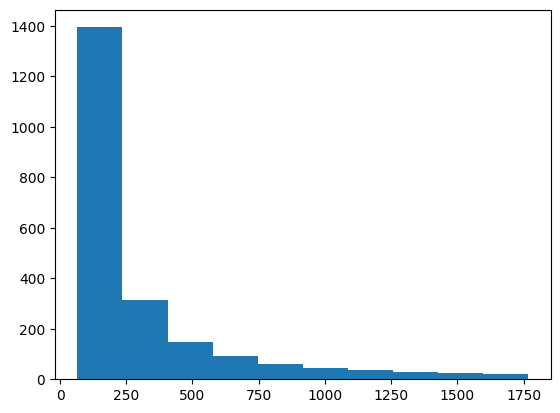

In [148]:
# read data use ssio

import ssio

test = ssio.read_SS('ss.0000010000')[0]
test2 = ss_in('ss.0000010000', units='mks')


# plt.hist(test[3] * au)
plt.hist(test[2] * M_sun) 

In [120]:
test[2]

array([3.2936164193133236e-29, 3.295651400037937e-29,
       3.297688477424116e-29, ..., 8.789437388832952e-28,
       8.838130828192655e-28, 8.88727553633202e-28], dtype=object)

In [100]:
Particles = ss_in('results/initcond.ss', units='mks')

Error: Invalid ss file.


In [48]:
Particles[0].R

0.2501467136336691

In [97]:


def plot_position_gif(filenames, output_path='gif/tau_0_3_R_3_2d.gif'):
    images = []

    for idx, filename in enumerate(filenames):
        print(f"Processing frame {idx} of {len(filenames)}")
        Particles = ss_in(filename, units='pkd')
        p_position = np.zeros((len(Particles), 3))
        p_radius = np.zeros(len(Particles))
        for i in range(len(Particles)):
            p_position[i] = np.array([Particles[i].x, Particles[i].y, Particles[i].z])
            p_radius = Particles[i].R

        fig = plt.figure()
        # ax = fig.add_subplot(111, projection='3d')
        # ax.scatter(p_position[:, 0], p_position[:, 1], p_position[:, 2], s=(p_radius * 100)**2, alpha=0.6)

        ax = fig.add_subplot(111)
        ax.scatter(p_position[:, 0], p_position[:, 1], s=(p_radius * 100)**2, alpha=0.6)

        # ax.set_xlim([-4, 4])
        # ax.set_ylim([-4, 4])
        # ax.set_zlim([-4, 4])
        ax.set_title(f'Frame {idx}')

        # Save the frame to a temporary image
        temp_filename = f'_frame_{idx}.png'
        plt.savefig(temp_filename, dpi=100)
        plt.close(fig)

        images.append(imageio.imread(temp_filename))

    # Save the images as a GIF
    imageio.mimsave(output_path, images)

    # Clean up temp files
    for idx in range(len(filenames)):
        os.remove(f'_frame_{idx}.png')

    print(f"GIF saved to {output_path}")



start_index = 0
end_index = 300000
filenames = ['results/tau_0_3_R_3/ss.' + str(i).zfill(10) +'.r' for i in range(start_index, end_index, 10000)]

print(filenames)

plot_position_gif(filenames)

['results/tau_0_3_R_3/ss.0000000000.r', 'results/tau_0_3_R_3/ss.0000010000.r', 'results/tau_0_3_R_3/ss.0000020000.r', 'results/tau_0_3_R_3/ss.0000030000.r', 'results/tau_0_3_R_3/ss.0000040000.r', 'results/tau_0_3_R_3/ss.0000050000.r', 'results/tau_0_3_R_3/ss.0000060000.r', 'results/tau_0_3_R_3/ss.0000070000.r', 'results/tau_0_3_R_3/ss.0000080000.r', 'results/tau_0_3_R_3/ss.0000090000.r', 'results/tau_0_3_R_3/ss.0000100000.r', 'results/tau_0_3_R_3/ss.0000110000.r', 'results/tau_0_3_R_3/ss.0000120000.r', 'results/tau_0_3_R_3/ss.0000130000.r', 'results/tau_0_3_R_3/ss.0000140000.r', 'results/tau_0_3_R_3/ss.0000150000.r', 'results/tau_0_3_R_3/ss.0000160000.r', 'results/tau_0_3_R_3/ss.0000170000.r', 'results/tau_0_3_R_3/ss.0000180000.r', 'results/tau_0_3_R_3/ss.0000190000.r', 'results/tau_0_3_R_3/ss.0000200000.r', 'results/tau_0_3_R_3/ss.0000210000.r', 'results/tau_0_3_R_3/ss.0000220000.r', 'results/tau_0_3_R_3/ss.0000230000.r', 'results/tau_0_3_R_3/ss.0000240000.r', 'results/tau_0_3_R_3/ss.

/var/folders/yx/n0ldhkpn0hq62r679b3mq7tm0000gn/T/ipykernel_9417/1768670319.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


Processing frame 2 of 30
Processing frame 3 of 30
Processing frame 4 of 30
Processing frame 5 of 30
Processing frame 6 of 30
Processing frame 7 of 30
Processing frame 8 of 30
Processing frame 9 of 30
Processing frame 10 of 30
Processing frame 11 of 30
Processing frame 12 of 30
Processing frame 13 of 30
Processing frame 14 of 30
Processing frame 15 of 30
Processing frame 16 of 30
Processing frame 17 of 30
Processing frame 18 of 30
Processing frame 19 of 30
Processing frame 20 of 30
Processing frame 21 of 30
Processing frame 22 of 30
Processing frame 23 of 30
Processing frame 24 of 30
Processing frame 25 of 30
Processing frame 26 of 30
Processing frame 27 of 30
Processing frame 28 of 30
Processing frame 29 of 30
GIF saved to gif/tau_0_3_R_3_2d.gif


array([0.25015027409475615, 0.2502972484225756, 0.25044448211690395,
       0.2505919759414825, 0.2507397306110057, 0.25088774705213385,
       0.2510360258815177, 0.2511845679278077, 0.25133337386553306,
       0.25148244468769854, 0.2516317810755115, 0.25178138392411137,
       0.25193125381500053, 0.25208139164972626, 0.25223179822764397,
       0.2523824743514515, 0.25253342082720737, 0.25268463825065507,
       0.25283612786163157, 0.25298789026307583, 0.25313992627467097,
       0.25329223671955253, 0.2534448224243269, 0.25359768443510916,
       0.2537508229374487, 0.2539042396333374, 0.2540579344970284,
       0.2542119092407693, 0.25436616384281413, 0.25452070002576316,
       0.25467551777193076, 0.2548306188143682, 0.25498600313951003,
       0.2551416724909581, 0.25529762685932833, 0.25545386755727995,
       0.25561039590445306, 0.2557672118978523, 0.2559243173078985,
       0.25608171213593456, 0.2562393981632896, 0.2563973753957091,
       0.25655564562553557, 0.25671420

2.7230485098720085


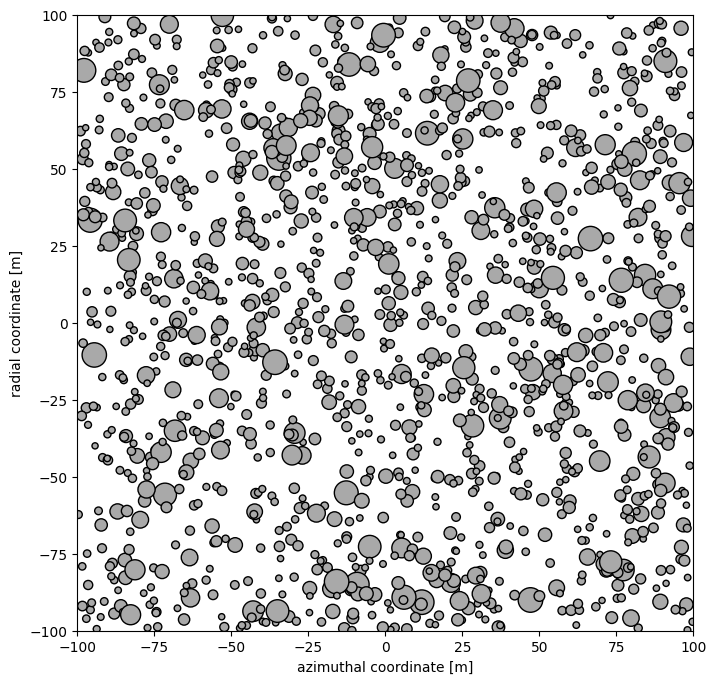

In [212]:
import rebound
import numpy as np
sim = rebound.Simulation()

OMEGA = 0.00013143527     # [1/s]

sim.ri_sei.OMEGA = OMEGA
surface_density = 400.    # kg/m^2
particle_density = 400.   # kg/m^3
sim.G = 6.67428e-11       # N m^2 / kg^2
sim.dt = 1e-3*2.*np.pi/OMEGA
sim.softening = 0.2       # [m]
boxsize = 200.            # [m]

tau = surface_density / particle_density / 1


Q = np.sqrt(G * 4/3 * np.pi * particle_density * 3**3) * OMEGA / np.pi / G / surface_density

sim.configure_box(boxsize)
sim.N_ghost_x = 2
sim.N_ghost_y = 2
sim.integrator = "sei"
sim.boundary   = "shear"
sim.gravity    = "tree"
sim.collision  = "tree"
sim.collision_resolve = "hardsphere"
def cor_bridges(r, v):
        eps = 0.32*pow(abs(v)*100.,-0.234)
        if eps>1.:
            eps=1.
        if eps<0.:
            eps=0.
        return eps
sim.coefficient_of_restitution = cor_bridges

def powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

total_mass = 0.
while total_mass < surface_density*(boxsize**2):
    radius = powerlaw(slope=-3, min_v=1, max_v=4)  # [m]    
    mass = particle_density*4./3.*np.pi*(radius**3)
    x = np.random.uniform(low=-boxsize/2., high=boxsize/2.)
    sim.add(
        m=mass,
        r=radius,
        x=x,
        y=np.random.uniform(low=-boxsize/2., high=boxsize/2.),
        z=np.random.normal(),
        vx = 0.,
        vy = -3./2.*x*OMEGA, 
        vz = 0.)
    total_mass += mass

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plotParticles(sim):
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,aspect='equal')
    ax.set_ylabel("radial coordinate [m]")
    ax.set_xlabel("azimuthal coordinate [m]")
    ax.set_ylim(-boxsize/2.,boxsize/2.)
    ax.set_xlim(-boxsize/2.,boxsize/2.)

    for i, p in enumerate(sim.particles):
        circ = patches.Circle((p.y, p.x), p.r, facecolor='darkgray', edgecolor='black')
        ax.add_patch(circ)

plotParticles(sim)
print(Q)

In [214]:
sim.integrate(2.*np.pi/OMEGA)


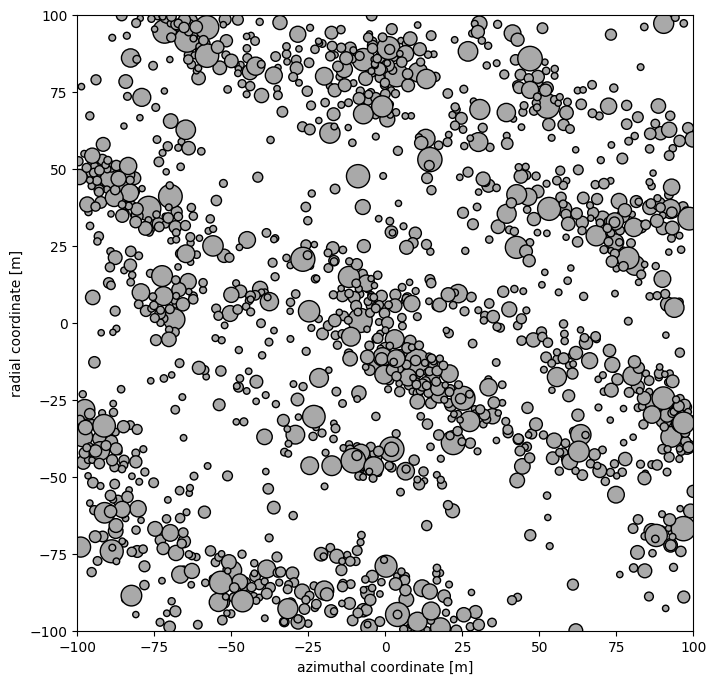

In [215]:
plotParticles(sim)